<a href="https://colab.research.google.com/github/Qqqsse/HW9_LLM_Finetune_Emotion_Risk/blob/main/HW9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================================
# 儲存格 1：所有 import 與函數定義（修正版）
# ============================================

# 基礎套件
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
from torch.utils.data import Dataset, DataLoader

# HuggingFace
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)

# PEFT (LoRA)
from peft import (
    LoraConfig,
    get_peft_model,
    prepare_model_for_kbit_training,
    TaskType
)

# 評估指標
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report
)
from sklearn.preprocessing import label_binarize

print("所有套件載入完成！")

# ============================================
# 風險映射規則（修正版）
# ============================================
EMOTION_NAMES = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
RISK_NAMES = ['low_risk', 'mid_risk', 'high_risk']

# 正確的映射規則
EMOTION_TO_RISK = {
    0: 2,  # sadness → high_risk (2)
    1: 0,  # joy → low_risk (0)
    2: 0,  # love → low_risk (0)
    3: 1,  # anger → mid_risk (1)
    4: 1,  # fear → mid_risk (1)
    5: 0   # surprise → low_risk (0)
}

def map_emotion_to_risk(emotion_label):
    """將情緒標籤映射到風險等級"""
    return EMOTION_TO_RISK[emotion_label]

# ============================================
# 資料預處理函數
# ============================================
def preprocess_data(dataset_split):
    """將 HuggingFace dataset 轉換為 DataFrame 並加入 risk_label"""
    data = []
    for item in dataset_split:
        data.append({
            'text': item['text'],
            'emotion': item['label'],
            'emotion_name': EMOTION_NAMES[item['label']],
            'risk_label': map_emotion_to_risk(item['label']),
            'risk_name': RISK_NAMES[map_emotion_to_risk(item['label'])]
        })
    return pd.DataFrame(data)

# ============================================
# Prompt 建構函數
# ============================================
def create_zero_shot_prompt(text):
    """建立 Zero-shot prompt"""
    prompt = f"""Classify the emotion and depression risk level of the following text.

Text: {text}

Classify the emotion as one of: sadness, joy, love, anger, fear, surprise
Classify the risk level as one of: low_risk, mid_risk, high_risk

Answer in this format:
Emotion: <emotion>
Risk: <risk_level>"""
    return prompt

def create_few_shot_prompt(text, examples):
    """建立 Few-shot prompt with examples"""
    prompt = "Here are some examples of emotion and risk classification:\n\n"

    for i, ex in enumerate(examples, 1):
        prompt += f"Example {i}:\n"
        prompt += f"Text: {ex['text']}\n"
        prompt += f"Emotion: {ex['emotion_name']}\n"
        prompt += f"Risk: {ex['risk_name']}\n\n"

    prompt += f"Now classify this text:\nText: {text}\n\n"
    prompt += "Answer in this format:\nEmotion: <emotion>\nRisk: <risk_level>"

    return prompt

def create_training_prompt(text, emotion_name, risk_name):
    """建立訓練用的 prompt（含答案）"""
    prompt = f"""Classify the emotion and depression risk level of the following text.

Text: {text}

Emotion: {emotion_name}
Risk: {risk_name}"""
    return prompt

def create_lora_inference_prompt(text):
    """
    建立 LoRA 推論用的 prompt
    必須與訓練時的格式一致，但不包含答案
    """
    prompt = f"""Classify the emotion and depression risk level of the following text.

Text: {text}

Emotion:"""
    return prompt

# ============================================
# 推論與解析函數
# ============================================
def parse_response(response):
    """解析模型輸出，提取 emotion 和 risk"""
    emotion, risk = None, None

    response = response.strip().lower()

    lines = response.split('\n')

    for i, line in enumerate(lines):
        line = line.strip()

        # 方法1: 找 "emotion:" 開頭
        if line.startswith('emotion:'):
            emotion = line.split('emotion:')[-1].strip()
        # 方法2: 找 "risk:" 開頭
        elif line.startswith('risk:'):
            risk = line.split('risk:')[-1].strip()
        # 方法3: 第一行如果是情緒詞，就當作 emotion
        elif i == 0 and not emotion:
            for e in EMOTION_NAMES:
                if e in line:
                    emotion = e
                    break
        # 方法4: 任何包含 "risk:" 的行
        elif 'risk:' in line:
            risk = line.split('risk:')[-1].strip()

    # 映射到標準格式
    if emotion and emotion not in EMOTION_NAMES:
        for e in EMOTION_NAMES:
            if e in emotion:
                emotion = e
                break

    if risk and risk not in RISK_NAMES:
        for r in RISK_NAMES:
            if r in risk:
                risk = r
                break

    return emotion, risk

def inference_single(model, tokenizer, prompt, max_new_tokens=100):
    """單一樣本推論"""
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.7,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # 移除 prompt 部分
    if prompt in response:
        response = response.replace(prompt, "").strip()

    return response

def batch_inference(model, tokenizer, df, prompt_fn, batch_size=8):
    """批次推論"""
    predictions = []

    for i in tqdm(range(0, len(df), batch_size), desc="推論中"):
        batch = df.iloc[i:i+batch_size]

        for _, row in batch.iterrows():
            prompt = prompt_fn(row['text'])
            response = inference_single(model, tokenizer, prompt)
            emotion, risk = parse_response(response)

            predictions.append({
                'text': row['text'],
                'true_emotion': row['emotion_name'],
                'true_risk': row['risk_name'],
                'pred_emotion': emotion,
                'pred_risk': risk,
                'response': response
            })

    return pd.DataFrame(predictions)

# ============================================
# 評估指標函數（新增 AUROC 和 PR-AUC）
# ============================================
def evaluate_predictions(pred_df):
    """計算評估指標（包含 AUROC 和 PR-AUC）"""
    # 轉換為數值標籤
    emotion_to_idx = {e: i for i, e in enumerate(EMOTION_NAMES)}
    risk_to_idx = {r: i for i, r in enumerate(RISK_NAMES)}

    # 處理 None 值
    pred_df = pred_df.copy()

    most_common_emotion = pred_df['pred_emotion'].mode()[0] if len(pred_df['pred_emotion'].mode()) > 0 else 'joy'
    most_common_risk = pred_df['pred_risk'].mode()[0] if len(pred_df['pred_risk'].mode()) > 0 else 'low_risk'

    pred_df['pred_emotion'] = pred_df['pred_emotion'].fillna(most_common_emotion)
    pred_df['pred_risk'] = pred_df['pred_risk'].fillna(most_common_risk)

    pred_df['pred_emotion'] = pred_df['pred_emotion'].apply(
        lambda x: x if x in emotion_to_idx else most_common_emotion
    )
    pred_df['pred_risk'] = pred_df['pred_risk'].apply(
        lambda x: x if x in risk_to_idx else most_common_risk
    )

    y_true_emotion = pred_df['true_emotion'].map(emotion_to_idx).values
    y_pred_emotion = pred_df['pred_emotion'].map(emotion_to_idx).values

    y_true_risk = pred_df['true_risk'].map(risk_to_idx).values
    y_pred_risk = pred_df['pred_risk'].map(risk_to_idx).values

    # 基本指標
    results = {
        'emotion_f1_macro': f1_score(y_true_emotion, y_pred_emotion, average='macro'),
        'emotion_f1_weighted': f1_score(y_true_emotion, y_pred_emotion, average='weighted'),
        'risk_f1_macro': f1_score(y_true_risk, y_pred_risk, average='macro'),
        'risk_f1_weighted': f1_score(y_true_risk, y_pred_risk, average='weighted'),
    }

    # AUROC 和 PR-AUC（多分類需要 One-vs-Rest）
    try:
        # Emotion AUROC
        y_true_emotion_bin = label_binarize(y_true_emotion, classes=range(len(EMOTION_NAMES)))
        y_pred_emotion_bin = label_binarize(y_pred_emotion, classes=range(len(EMOTION_NAMES)))

        emotion_auroc = roc_auc_score(y_true_emotion_bin, y_pred_emotion_bin, average='macro', multi_class='ovr')
        emotion_prauc = average_precision_score(y_true_emotion_bin, y_pred_emotion_bin, average='macro')

        results['emotion_auroc'] = emotion_auroc
        results['emotion_prauc'] = emotion_prauc
    except:
        results['emotion_auroc'] = 0.0
        results['emotion_prauc'] = 0.0

    try:
        # Risk AUROC
        y_true_risk_bin = label_binarize(y_true_risk, classes=range(len(RISK_NAMES)))
        y_pred_risk_bin = label_binarize(y_pred_risk, classes=range(len(RISK_NAMES)))

        risk_auroc = roc_auc_score(y_true_risk_bin, y_pred_risk_bin, average='macro', multi_class='ovr')
        risk_prauc = average_precision_score(y_true_risk_bin, y_pred_risk_bin, average='macro')

        results['risk_auroc'] = risk_auroc
        results['risk_prauc'] = risk_prauc
    except:
        results['risk_auroc'] = 0.0
        results['risk_prauc'] = 0.0

    # Confusion Matrix
    cm_emotion = confusion_matrix(y_true_emotion, y_pred_emotion)
    cm_risk = confusion_matrix(y_true_risk, y_pred_risk)

    return results, cm_emotion, cm_risk

def plot_confusion_matrix(cm, labels, title):
    """繪製混淆矩陣"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# ============================================
# 風險視覺化函數
# ============================================
def plot_risk_trend(pred_df, window_size=50):
    """繪製高風險走勢圖"""
    is_high_risk = (pred_df['pred_risk'] == 'high_risk').astype(int)
    high_risk_prob = is_high_risk.rolling(window=window_size, min_periods=1).mean()

    plt.figure(figsize=(14, 6))
    plt.plot(high_risk_prob, linewidth=1.5, alpha=0.7)
    plt.axhline(y=0.3, color='orange', linestyle='--', label='Warning Threshold (0.3)')
    plt.axhline(y=0.5, color='red', linestyle='--', label='Critical Threshold (0.5)')
    plt.title(f'High Risk Trend (Rolling Window = {window_size})')
    plt.xlabel('Sample Index')
    plt.ylabel('P(high_risk)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_risk_heatmap(pred_df, window_size=50, step=10):
    """繪製高風險濃度熱圖"""
    is_high_risk = (pred_df['pred_risk'] == 'high_risk').astype(int).values

    heatmap_data = []
    positions = []

    for i in range(0, len(is_high_risk) - window_size, step):
        window = is_high_risk[i:i+window_size]
        heatmap_data.append(window.mean())
        positions.append(i)

    heatmap_matrix = np.array(heatmap_data).reshape(-1, 1).T

    plt.figure(figsize=(14, 3))
    sns.heatmap(heatmap_matrix, cmap='Reds', cbar_kws={'label': 'P(high_risk)'},
                xticklabels=[f'{p}' for p in positions[::5]], yticklabels=['Risk Level'])
    plt.title(f'High Risk Density Heatmap (Window={window_size}, Step={step})')
    plt.xlabel('Sample Index')
    plt.tight_layout()
    plt.show()

# ============================================
# LoRA 微調相關函數
# ============================================
class EmotionRiskDataset(Dataset):
    """自定義 Dataset for LoRA training"""
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': encoding['input_ids'].flatten()
        }

def prepare_lora_model(model_name, use_4bit=True):
    """準備 LoRA 模型（修正 target_modules）"""
    if use_4bit:
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
        )
    else:
        bnb_config = None

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True
    )

    if use_4bit:
        model = prepare_model_for_kbit_training(model)

    # 自動檢測 target_modules
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj"]

    print(f"Target modules: {target_modules}")

    # 去重並確保至少有基本的 attention modules
    target_modules = list(set(target_modules))
    if not target_modules:
        target_modules = ["q_proj", "v_proj"]  # 預設值

    print(f"Detected target_modules: {target_modules}")

    lora_config = LoraConfig(
        r=16,
        lora_alpha=32,
        target_modules=target_modules,
        lora_dropout=0.05,
        bias="none",
        task_type=TaskType.CAUSAL_LM
    )

    model = get_peft_model(model, lora_config)
    model.print_trainable_parameters()

    return model

print("\n所有函數定義完成！")

所有套件載入完成！

所有函數定義完成！


In [ ]:
import warnings
warnings.filterwarnings('ignore')
!pip install -U -q bitsandbytes accelerate peft
!pip install -q datasets
print("套件安裝完成！")

套件安裝完成！


HW9: 情緒分類與憂鬱症風險監測

[Step 1] 載入 Emotion Dataset...
Train samples: 16000
Validation samples: 2000
Test samples: 2000

風險標籤分布 (Train):
risk_name
low_risk     7238
high_risk    4666
mid_risk     4096
Name: count, dtype: int64

情緒標籤分布 (Train):
emotion_name
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

[Step 2] 載入模型與 Tokenizer...


`torch_dtype` is deprecated! Use `dtype` instead!


模型載入完成: Qwen/Qwen2.5-1.5B-Instruct
Device: cuda:0

[Step 3] Zero-shot 推論...


推論中: 100%|██████████| 25/25 [04:37<00:00, 11.08s/it]



Zero-shot 範例輸出:
                                                text  true_risk pred_risk
0  im feeling rather rotten so im not very ambiti...  high_risk      None
1          im updating my blog because i feel shitty  high_risk  low_risk
2  i never make her separate from me because i do...  high_risk  low_risk

Zero-shot 評估結果:
emotion_f1_macro: 0.3504
emotion_f1_weighted: 0.4198
risk_f1_macro: 0.3442
risk_f1_weighted: 0.3650
emotion_auroc: 0.6227
emotion_prauc: 0.2710
risk_auroc: 0.5505
risk_prauc: 0.3615

[Step 4] Few-shot 推論...


推論中: 100%|██████████| 25/25 [04:35<00:00, 11.04s/it]



Few-shot 範例輸出:
                                                text  true_risk    pred_risk
0  im feeling rather rotten so im not very ambiti...  high_risk  medium_risk
1          im updating my blog because i feel shitty  high_risk         None
2  i never make her separate from me because i do...  high_risk         None

Few-shot 評估結果:
emotion_f1_macro: 0.0722
emotion_f1_weighted: 0.0872
risk_f1_macro: 0.2988
risk_f1_weighted: 0.3283
emotion_auroc: 0.5031
emotion_prauc: 0.1753
risk_auroc: 0.5435
risk_prauc: 0.3592

[Step 5] 準備 LoRA 微調...
訓練樣本數: 16000
驗證樣本數: 2000

[Step 6] 開始 LoRA 微調...
Target modules: ['q_proj', 'k_proj', 'v_proj', 'o_proj']
Detected target_modules: ['o_proj', 'v_proj', 'q_proj', 'k_proj']
trainable params: 4,358,144 || all params: 1,548,072,448 || trainable%: 0.2815


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


開始訓練...


Step,Training Loss,Validation Loss
200,0.299900,0.289421
400,0.292600,0.283186
600,0.281700,0.280667
800,0.279200,0.279086
1000,0.290200,0.277919
1200,0.284100,0.277358
1400,0.287200,0.276896
1600,0.277500,0.276490
1800,0.273800,0.276125
2000,0.281800,0.275925



訓練完成！
模型已儲存到 ./lora_emotion_risk_model

[Step 7] LoRA 微調後推論...


推論中: 100%|██████████| 25/25 [01:26<00:00,  3.46s/it]



LoRA 範例輸出:
                                                text  true_risk  pred_risk
0  im feeling rather rotten so im not very ambiti...  high_risk  high_risk
1          im updating my blog because i feel shitty  high_risk  high_risk
2  i never make her separate from me because i do...  high_risk  high_risk

LoRA 評估結果:
emotion_f1_macro: 0.7599
emotion_f1_weighted: 0.7984
risk_f1_macro: 0.8769
risk_f1_weighted: 0.8778
emotion_auroc: 0.8679
emotion_prauc: 0.6402
risk_auroc: 0.9056
risk_prauc: 0.8140

=== 除錯資訊 ===
前 5 筆完整輸出:

樣本 1:
Text: im feeling rather rotten so im not very ambitious ...
Response: sadness
Risk: high_risk
Parsed - Emotion: sadness, Risk: high_risk

樣本 2:
Text: im updating my blog because i feel shitty...
Response: sadness
Risk: high_risk
Parsed - Emotion: sadness, Risk: high_risk

樣本 3:
Text: i never make her separate from me because i don t ...
Response: sadness
Risk: high_risk
Parsed - Emotion: sadness, Risk: high_risk

樣本 4:
Text: i left with my bouquet of red and

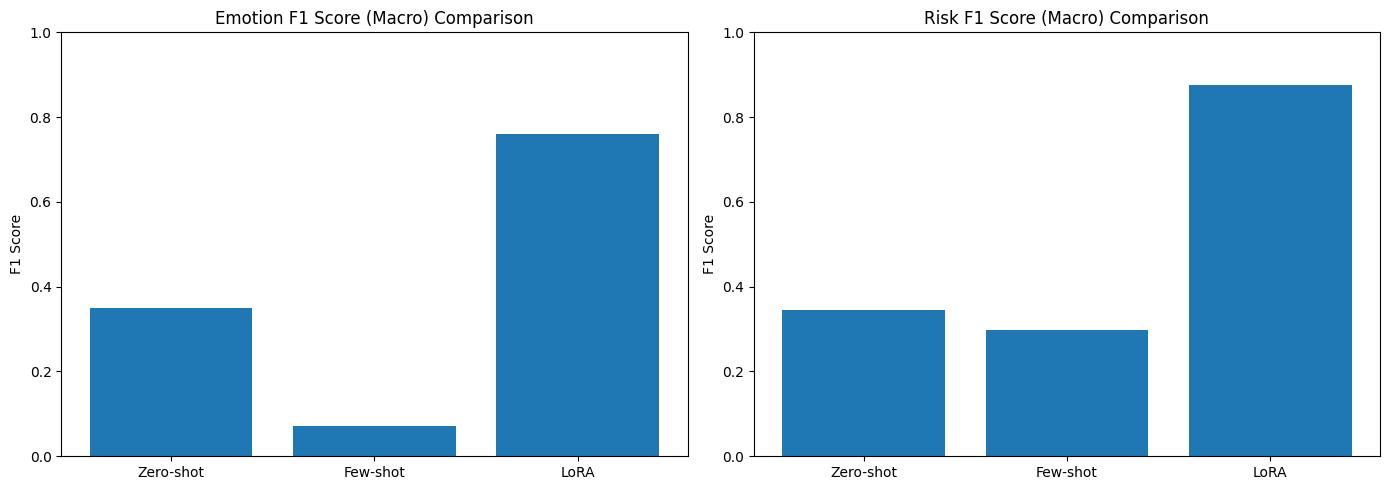


[Step 9] 混淆矩陣視覺化


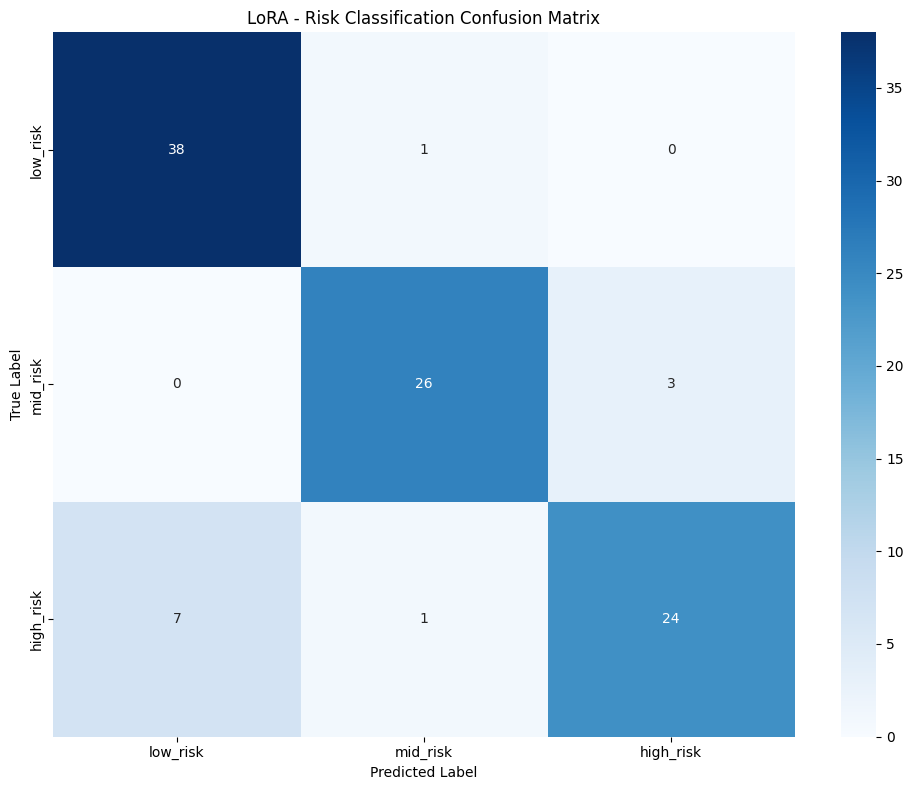

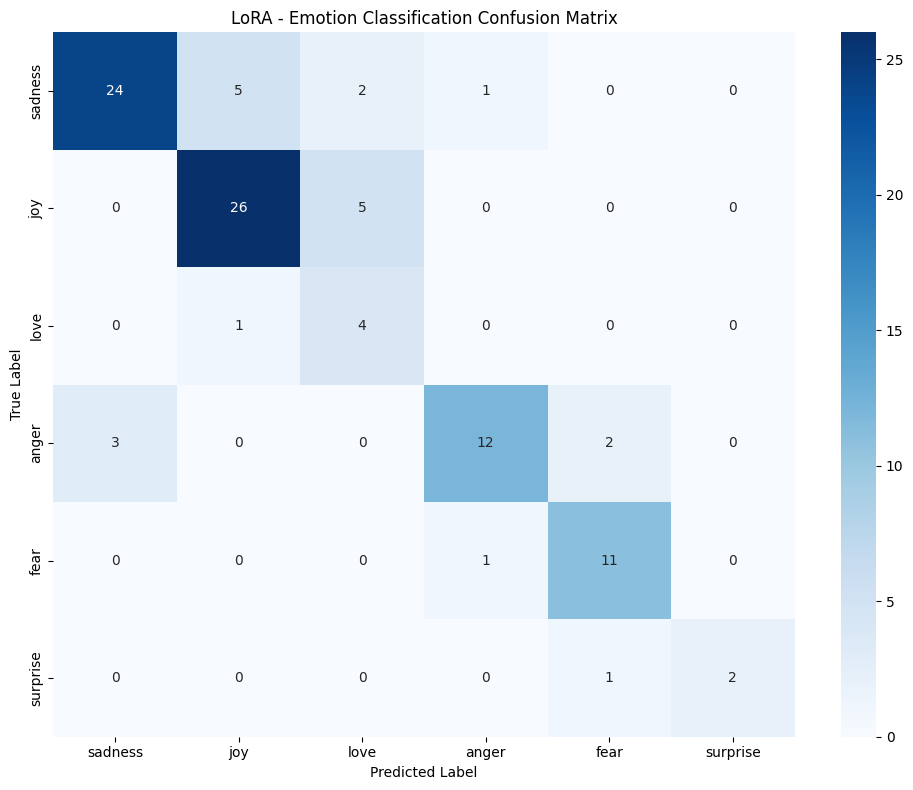


[Step 10] 風險監測視覺化
對完整測試集進行推論...


推論中: 100%|██████████| 125/125 [07:11<00:00,  3.46s/it]


繪製高風險走勢圖...


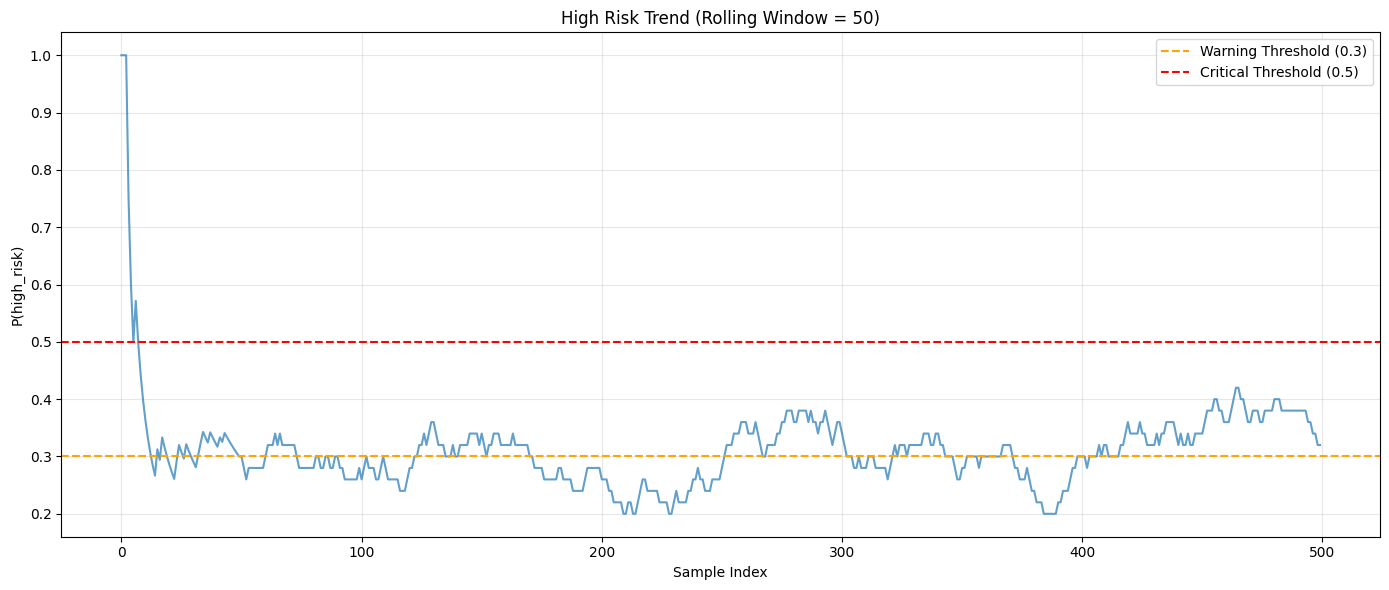


繪製高風險濃度熱圖...


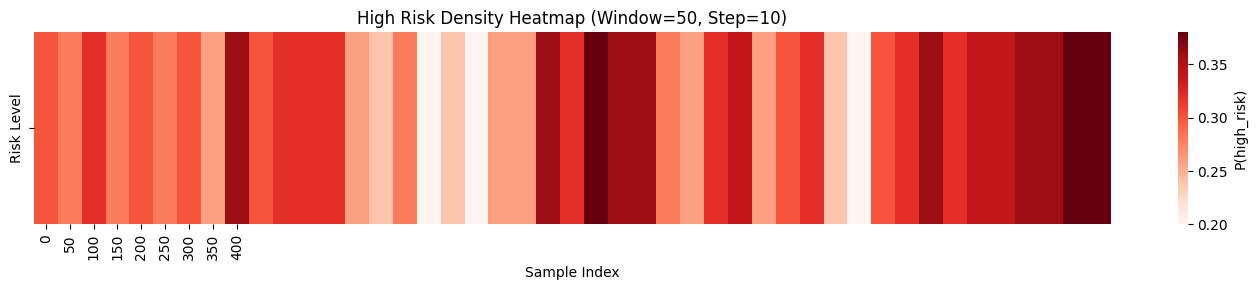


[Step 11] 儲存結果...
結果已儲存！

檔案列表:
- zero_shot_predictions.csv
- few_shot_predictions.csv
- lora_predictions.csv
- method_comparison.csv
- ./lora_emotion_risk_model/ (微調後的模型)

作業完成！


In [ ]:
# ============================================
# 儲存格 2：主程式執行
# ============================================

print("="*60)
print("HW9: 情緒分類與憂鬱症風險監測")
print("="*60)

# ============================================
# Step 1: 載入資料集
# ============================================
print("\n[Step 1] 載入 Emotion Dataset...")
dataset = load_dataset("dair-ai/emotion")

print(f"Train samples: {len(dataset['train'])}")
print(f"Validation samples: {len(dataset['validation'])}")
print(f"Test samples: {len(dataset['test'])}")

# 轉換為 DataFrame
train_df = preprocess_data(dataset['train'])
val_df = preprocess_data(dataset['validation'])
test_df = preprocess_data(dataset['test'])

print(f"\n風險標籤分布 (Train):")
print(train_df['risk_name'].value_counts())

print(f"\n情緒標籤分布 (Train):")
print(train_df['emotion_name'].value_counts())

# ============================================
# Step 2: 載入基礎模型
# ============================================
print("\n[Step 2] 載入模型與 Tokenizer...")
MODEL_NAME = "Qwen/Qwen2.5-1.5B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    torch_dtype=torch.float16,
    trust_remote_code=True
)

print(f"模型載入完成: {MODEL_NAME}")
print(f"Device: {model.device}")

# ============================================
# Step 3: Zero-shot 推論
# ============================================
print("\n[Step 3] Zero-shot 推論...")
test_sample = test_df.head(100)  # 使用前100筆測試

zero_shot_results = batch_inference(
    model,
    tokenizer,
    test_sample,
    create_zero_shot_prompt,
    batch_size=4
)

print("\nZero-shot 範例輸出:")
print(zero_shot_results[['text', 'true_risk', 'pred_risk']].head(3))

# 評估
zs_metrics, zs_cm_emotion, zs_cm_risk = evaluate_predictions(zero_shot_results)
print("\nZero-shot 評估結果:")
for key, value in zs_metrics.items():
    print(f"{key}: {value:.4f}")

# ============================================
# Step 4: Few-shot 推論
# ============================================
print("\n[Step 4] Few-shot 推論...")

# 選擇示例（每個風險類別各1個）
examples = []
for risk in ['low_risk', 'mid_risk', 'high_risk']:
    sample = train_df[train_df['risk_name'] == risk].iloc[0]
    examples.append(sample)

few_shot_prompt_fn = lambda text: create_few_shot_prompt(text, examples)

few_shot_results = batch_inference(
    model,
    tokenizer,
    test_sample,
    few_shot_prompt_fn,
    batch_size=4
)

print("\nFew-shot 範例輸出:")
print(few_shot_results[['text', 'true_risk', 'pred_risk']].head(3))

# 評估
fs_metrics, fs_cm_emotion, fs_cm_risk = evaluate_predictions(few_shot_results)
print("\nFew-shot 評估結果:")
for key, value in fs_metrics.items():
    print(f"{key}: {value:.4f}")

# ============================================
# Step 5: 準備 LoRA 微調資料
# ============================================
print("\n[Step 5] 準備 LoRA 微調...")

# 準備訓練文本
train_texts = []
for _, row in train_df.iterrows():
    prompt = create_training_prompt(row['text'], row['emotion_name'], row['risk_name'])
    train_texts.append(prompt)

val_texts = []
for _, row in val_df.iterrows():
    prompt = create_training_prompt(row['text'], row['emotion_name'], row['risk_name'])
    val_texts.append(prompt)

# 建立 Dataset
train_dataset = EmotionRiskDataset(train_texts, None, tokenizer, max_length=256)
val_dataset = EmotionRiskDataset(val_texts, None, tokenizer, max_length=256)

print(f"訓練樣本數: {len(train_dataset)}")
print(f"驗證樣本數: {len(val_dataset)}")

# ============================================
# Step 6: LoRA 微調
# ============================================
print("\n[Step 6] 開始 LoRA 微調...")

# 準備 LoRA 模型
lora_model = prepare_lora_model(MODEL_NAME, use_4bit=True)

# 訓練參數
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    learning_rate=1e-4,
    fp16=True,
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=200,
    save_strategy="steps",
    save_steps=200,
    save_total_limit=2,
    load_best_model_at_end=True,
    report_to="none",
    warmup_steps=100,
    weight_decay=0.01,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
)

# Trainer
trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# 開始訓練
print("開始訓練...")
trainer.train()

print("\n訓練完成！")

# 儲存模型
lora_model.save_pretrained("./lora_emotion_risk_model")
tokenizer.save_pretrained("./lora_emotion_risk_model")
print("模型已儲存到 ./lora_emotion_risk_model")

# ============================================
# Step 7: LoRA 微調後推論
# ============================================
print("\n[Step 7] LoRA 微調後推論...")

lora_results = batch_inference(
    lora_model,
    tokenizer,
    test_sample,
    create_lora_inference_prompt,
    batch_size=4
)

print("\nLoRA 範例輸出:")
print(lora_results[['text', 'true_risk', 'pred_risk']].head(3))

# 評估
lora_metrics, lora_cm_emotion, lora_cm_risk = evaluate_predictions(lora_results)
print("\nLoRA 評估結果:")
for key, value in lora_metrics.items():
    print(f"{key}: {value:.4f}")


# 在 Step 7 之後加入
print("\n=== 除錯資訊 ===")
print("前 5 筆完整輸出:")
for i in range(min(5, len(lora_results))):
   print(f"\n樣本 {i+1}:")
   print(f"Text: {lora_results.iloc[i]['text'][:50]}...")
   print(f"Response: {lora_results.iloc[i]['response']}")
   print(f"Parsed - Emotion: {lora_results.iloc[i]['pred_emotion']}, Risk: {lora_results.iloc[i]['pred_risk']}")

# 檢查預測分布
print("\n預測分布:")
print(lora_results['pred_risk'].value_counts())
print(lora_results['pred_emotion'].value_counts())

# ============================================
# Step 8: 結果比較
# ============================================
print("\n[Step 8] 三種方法結果比較")
print("="*60)

comparison_df = pd.DataFrame({
    'Method': ['Zero-shot', 'Few-shot', 'LoRA'],
    'Emotion F1 (Macro)': [
        zs_metrics['emotion_f1_macro'],
        fs_metrics['emotion_f1_macro'],
        lora_metrics['emotion_f1_macro']
    ],
    'Risk F1 (Macro)': [
        zs_metrics['risk_f1_macro'],
        fs_metrics['risk_f1_macro'],
        lora_metrics['risk_f1_macro']
    ],
    'Risk F1 (Weighted)': [
        zs_metrics['risk_f1_weighted'],
        fs_metrics['risk_f1_weighted'],
        lora_metrics['risk_f1_weighted']
    ]
})

print(comparison_df.to_string(index=False))

# 繪製比較圖
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

methods = comparison_df['Method']
axes[0].bar(methods, comparison_df['Emotion F1 (Macro)'])
axes[0].set_title('Emotion F1 Score (Macro) Comparison')
axes[0].set_ylabel('F1 Score')
axes[0].set_ylim(0, 1)

axes[1].bar(methods, comparison_df['Risk F1 (Macro)'])
axes[1].set_title('Risk F1 Score (Macro) Comparison')
axes[1].set_ylabel('F1 Score')
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

# ============================================
# Step 9: 混淆矩陣視覺化
# ============================================
print("\n[Step 9] 混淆矩陣視覺化")

# LoRA Risk Confusion Matrix
plot_confusion_matrix(lora_cm_risk, RISK_NAMES, 'LoRA - Risk Classification Confusion Matrix')

# LoRA Emotion Confusion Matrix
plot_confusion_matrix(lora_cm_emotion, EMOTION_NAMES, 'LoRA - Emotion Classification Confusion Matrix')

# ============================================
# Step 10: 風險監測視覺化
# ============================================
print("\n[Step 10] 風險監測視覺化")

# 使用完整測試集進行推論（用於視覺化）
print("對完整測試集進行推論...")
full_test_results = batch_inference(
    lora_model,
    tokenizer,
    test_df.head(500),  # 使用前500筆
    create_lora_inference_prompt,
    batch_size=4
)

# 高風險走勢圖
print("\n繪製高風險走勢圖...")
plot_risk_trend(full_test_results, window_size=50)

# 高風險濃度熱圖
print("\n繪製高風險濃度熱圖...")
plot_risk_heatmap(full_test_results, window_size=50, step=10)

# ============================================
# Step 11: 儲存結果
# ============================================
print("\n[Step 11] 儲存結果...")

# 儲存預測結果
zero_shot_results.to_csv('zero_shot_predictions.csv', index=False)
few_shot_results.to_csv('few_shot_predictions.csv', index=False)
lora_results.to_csv('lora_predictions.csv', index=False)

# 儲存比較表格
comparison_df.to_csv('method_comparison.csv', index=False)

print("結果已儲存！")
print("\n檔案列表:")
print("- zero_shot_predictions.csv")
print("- few_shot_predictions.csv")
print("- lora_predictions.csv")
print("- method_comparison.csv")
print("- ./lora_emotion_risk_model/ (微調後的模型)")

print("\n"+"="*60)
print("作業完成！")
print("="*60)